## ***Seattle Birdcall Classification using Neural Networks***
##### Submitted by ~ *Mahek Patel*



### Introduction
This project applies deep learning techniques to classify bird species based on their unique sounds. Using spectrograms derived from bird call audio clips collected in the Seattle area, we will explore how convolutional neural networks (CNNs) can effectively recognize auditory patterns. The task simulates a real-world scenario in ecological monitoring and species identification.

In [79]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import random
import os
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import Input
from sklearn.utils import class_weight
import IPython.display as ipd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [3]:
# Loading spectogram data
h5_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\bird_spectrograms.hdf5"
f = h5py.File(h5_path, 'r')
species_keys = list(f.keys())

# Loading trainging data
txt_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\train_extended.txt"
train_meta = pd.read_csv(txt_path)

# Loading the test MP3 files
test_dir = r"C:\Users\mehek\OneDrive\Desktop\STML 3\test_birds"
test_files = sorted([f for f in os.listdir(test_dir) if f.endswith('.mp3')])

test_data = []
for file in test_files:
    file_path = os.path.join(test_dir, file)
    audio, sr = librosa.load(file_path, sr=22050)
    test_data.append((file, audio, sr))

## Data Exploration

#### 1. Exploring 'bird_spectrograms.hdf5'

In [4]:
# HDF5 training exploration 
print("Bird names:")
for i, key in enumerate(species_keys):
    print(f"{i+1}. {key}")

print("\nBirds overview:")
for key in species_keys:
    shape = f[key].shape  
    print(f"{key}: {shape[2]} samples (shape: {shape})")

Bird names:
1. amecro
2. amerob
3. bewwre
4. bkcchi
5. daejun
6. houfin
7. houspa
8. norfli
9. rewbla
10. sonspa
11. spotow
12. whcspa

Birds overview:
amecro: 66 samples (shape: (128, 517, 66))
amerob: 172 samples (shape: (128, 517, 172))
bewwre: 144 samples (shape: (128, 517, 144))
bkcchi: 45 samples (shape: (128, 517, 45))
daejun: 125 samples (shape: (128, 517, 125))
houfin: 84 samples (shape: (128, 517, 84))
houspa: 630 samples (shape: (128, 517, 630))
norfli: 37 samples (shape: (128, 517, 37))
rewbla: 187 samples (shape: (128, 517, 187))
sonspa: 263 samples (shape: (128, 517, 263))
spotow: 137 samples (shape: (128, 517, 137))
whcspa: 91 samples (shape: (128, 517, 91))


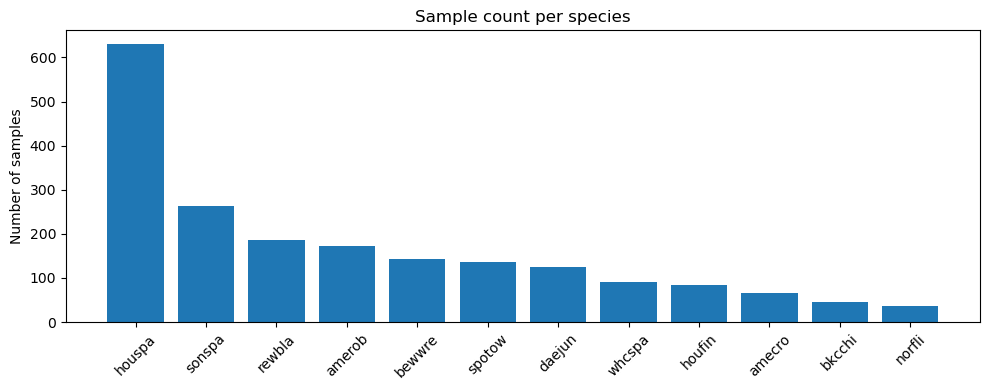

In [5]:
# Distribution of species 
species_counts = {key: f[key].shape[2] for key in species_keys}
sorted_counts = dict(sorted(species_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 4))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xticks(rotation=45)
plt.title("Sample count per species")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

Plot comments:
- 'houspa' has over 630 samples, dominating the dataset.

- Species like norfli, bkcchi, and amecro have fewer than 50 samples.

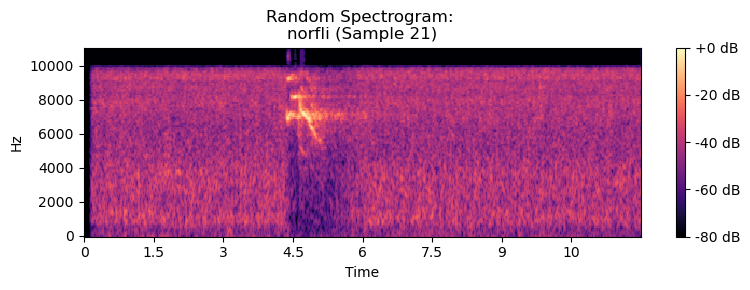

In [6]:
# Spectogram (for any random species)
def random_training():
    species_key = random.choice(species_keys)
    
    # Total number of samples for that species
    num_samples = f[species_key].shape[2]

    # Selectiing index
    index = random.randint(0, num_samples - 1)
    
    spec = f[species_key][:, :, index]
    plt.figure(figsize=(8, 3))
    librosa.display.specshow(spec, sr=22050, hop_length=512, x_axis='time', y_axis='linear')
    plt.title(f"Random Spectrogram: \n{species_key} (Sample {index})")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

random_training()

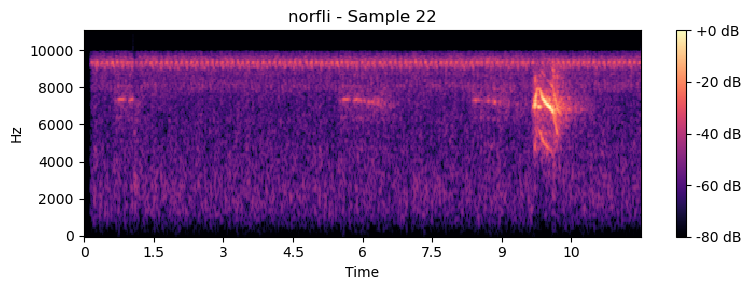

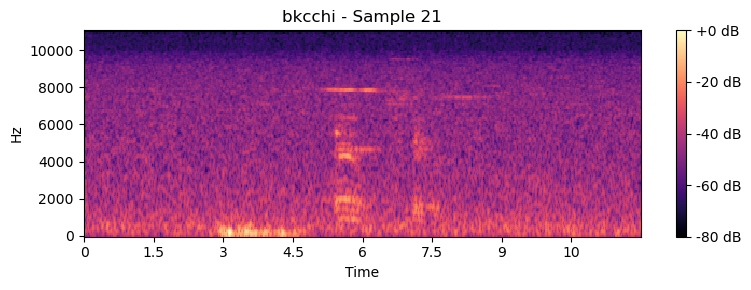

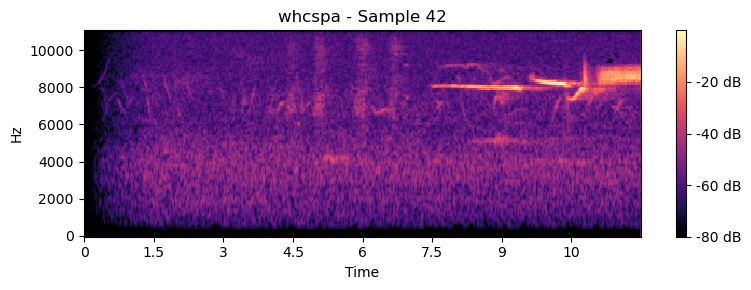

In [7]:
# Comparing any 3 random species
def random_spect(n_species=3):
    selected_species = random.sample(species_keys, n_species)

    for species in selected_species:
        index = random.randint(0, f[species].shape[2] - 1)
        spec = f[species][:, :, index]
        plt.figure(figsize=(8, 3))
        librosa.display.specshow(spec, sr=22050, hop_length=512, x_axis='time', y_axis='linear')
        plt.title(f"{species} - Sample {index}")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

random_spect(3)

#### 2. Exploring the test audio files

In [8]:
# Duration and testing rates of test (audio) files
print("\nTest Audio File Summary:")
for file, audio, sr in test_data:
    duration = len(audio) / sr
    print(f"{file}: duration = {duration:.2f} sec, sampling rate = {sr}")


Test Audio File Summary:
test1.mp3: duration = 23.28 sec, sampling rate = 22050
test2.mp3: duration = 5.25 sec, sampling rate = 22050
test3.mp3: duration = 15.88 sec, sampling rate = 22050


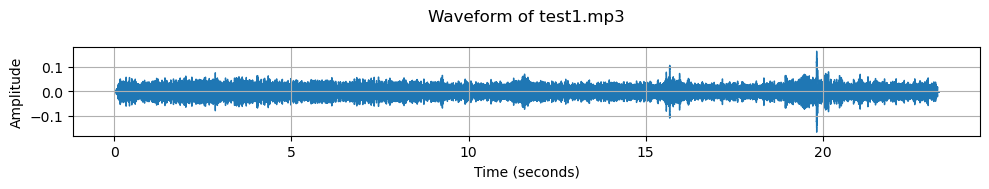

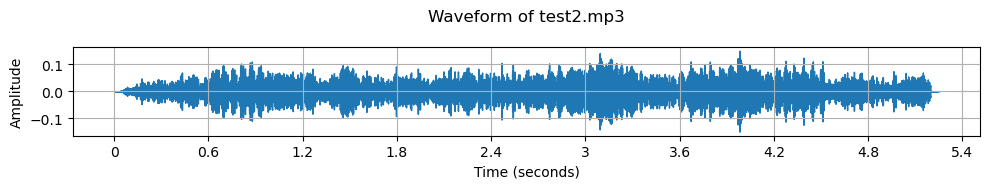

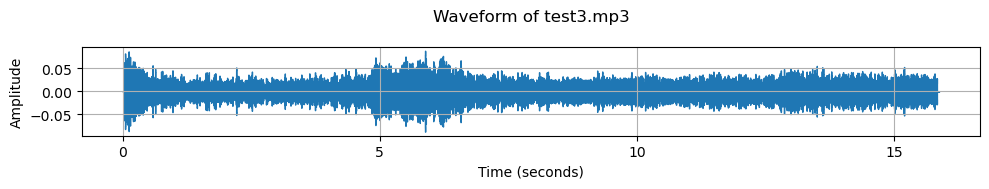

In [9]:
# Waveforms for all the test files
def all_test():
    for file, audio, sr in test_data:
        plt.figure(figsize=(10, 2))
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"Waveform of {file}\n")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
all_test()

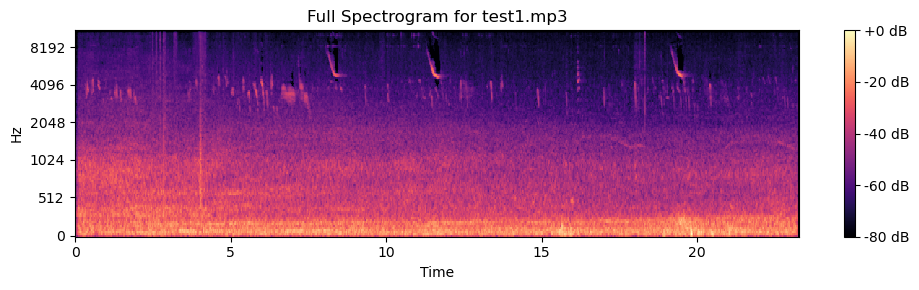

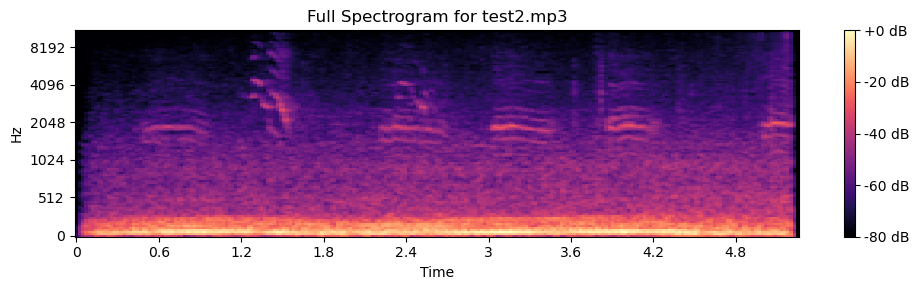

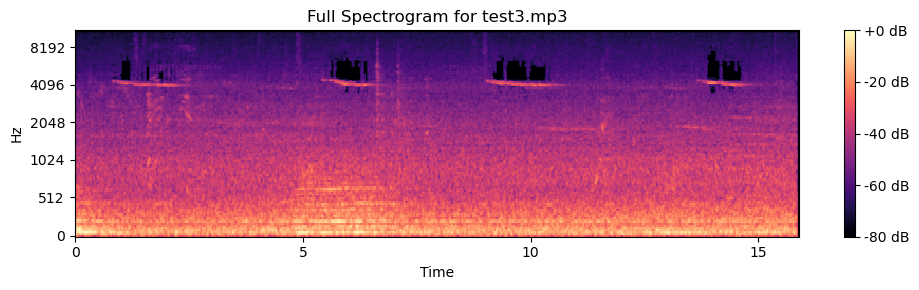

In [10]:
# Spectograms for test files
def all_test_spect(test_data):
    for file, audio, sr in test_data:
        # Generating mel-scaled spectrogram from full audio
        S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        plt.figure(figsize=(10, 3))
        librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Full Spectrogram for {file}")
        plt.tight_layout()
        plt.show()
all_test_spect(test_data)

Did this to visually explore the frequency content of each clip over its full duration and to understand where bird calls may occur. This might be further useful for discussion, analysis, hypothesis building and also find out if there's more than one bird species in it.

In [11]:
# Playing the test files

def play_test():
    for i, (file, audio, sr) in enumerate(test_data):
        print(f"\nPlaying Clip {i+1}: \n{file} | Duration: {len(audio)/sr:.2f} sec\n")
        display(ipd.Audio(audio, rate=sr))

play_test()


Playing Clip 1: 
test1.mp3 | Duration: 23.28 sec




Playing Clip 2: 
test2.mp3 | Duration: 5.25 sec




Playing Clip 3: 
test3.mp3 | Duration: 15.88 sec



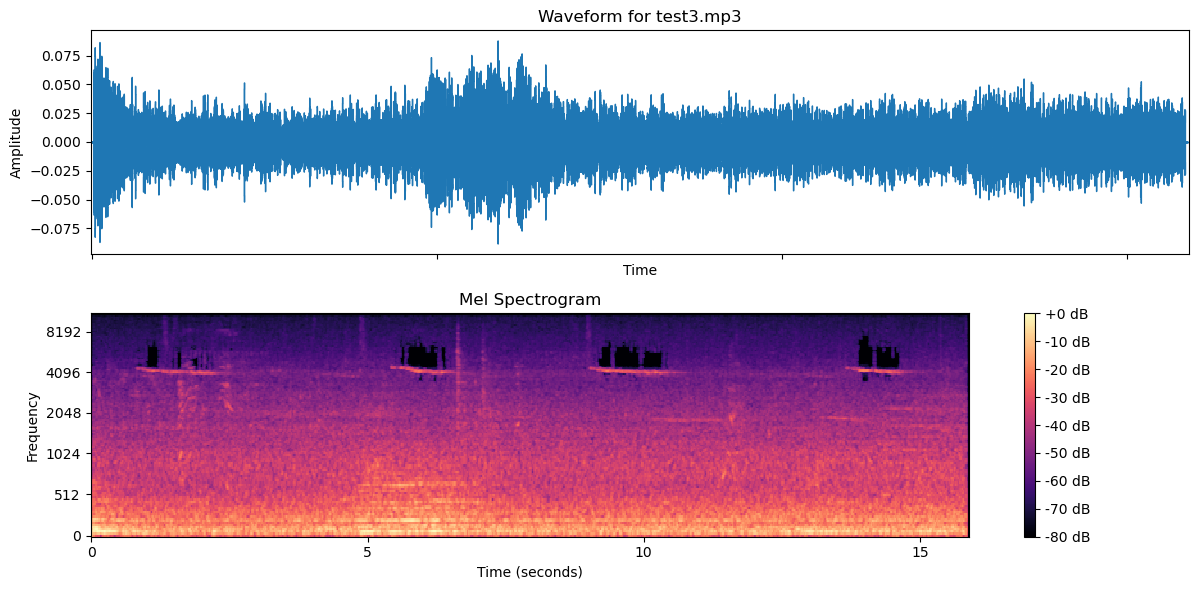

In [12]:
# Waveform + Spectrogram plot [OPTIONAL!]
def combined_test():
    # Randomly select a test clip
    file, audio, sr = random.choice(test_data)

    # Creating a mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plotting waveform and spectrogram in one frame
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # Waveform
    librosa.display.waveshow(audio, sr=sr, ax=ax[0])
    ax[0].set_title(f"Waveform for {file}")
    ax[0].set_ylabel("Amplitude")

    # Spectrogram
    img = librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set_title("Mel Spectrogram")
    ax[1].set_ylabel("Frequency")
    fig.colorbar(img, ax=ax[1], format="%+2.0f dB")

    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

combined_test()

# Kept it random to explore different clips

Performed this to visually correlate loudness spikes with frequency changes. Also helps to easily identify bird call regions in a test sample all at the same time.

#### 3. Exploring the metadata

In [13]:
# Exploring metadata
print("Metadata Shape:", train_meta.shape)
print("\nFirst few rows:")
train_meta.head()

Metadata Shape: (23784, 29)

First few rows:


rating playback_used ebird_code    channels        date  duration  \
0     0.0            no     aldfly  2 (stereo)  2019-06-11        49   
1     0.0            no     aldfly  2 (stereo)  2020-04-14        21   
2     0.0           yes     aldfly  2 (stereo)  2020-04-05        35   
3     0.0           yes     aldfly  2 (stereo)  2020-04-05        12   
4     0.0           yes     aldfly  2 (stereo)  2020-04-05        38   

       filename           species  \
0  XC554809.mp3  Alder Flycatcher   
1  XC552408.mp3  Alder Flycatcher   
2  XC544552.mp3  Alder Flycatcher   
3  XC544551.mp3  Alder Flycatcher   
4  XC544550.mp3  Alder Flycatcher   

                                           title secondary_labels  ...  \
0  XC554809 Alder Flycatcher (Empidonax alnorum)               []  ...   
1  XC552408 Alder Flycatcher (Empidonax alnorum)               []  ...   
2  XC544552 Alder Flycatcher (Empidonax alnorum)               []  ...   
3  XC544551 Alder Flycatcher (Empidonax alnorum)               []  ...   
4  XC544550 Alder Flycatcher (Empidonax alnorum)               []  ...   

  background   xc_id                                url        country  \
0        NaN  554809  https://www.xeno-canto.org/554809  United States   
1        NaN  552408  https://www.xeno-canto.org/552408       Colombia   
2        NaN  544552  https://www.xeno-canto.org/544552       Colombia   
3        NaN  544551  https://www.xeno-canto.org/544551       Colombia   
4        NaN  544550  https://www.xeno-canto.org/544550       Colombia   

           author                       primary_label longitude   time  \
0   Ron Overholtz  Empidonax alnorum_Alder Flycatcher -149.9757  07:00   
1  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  17:00   
2  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   
3  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   
4  Jerome Fischer  Empidonax alnorum_Alder Flycatcher  -74.6520  07:00   

        recordist                                            license  
0   Ron Overholtz  Creative Commons Attribution-NonCommercial-Sha...  
1  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
2  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
3  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  
4  Jerome Fischer  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 29 columns]

In [14]:
# Overview of columns and data types
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23784 entries, 0 to 23783
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            23784 non-null  float64
 1   playback_used     21938 non-null  object 
 2   ebird_code        23784 non-null  object 
 3   channels          23784 non-null  object 
 4   date              23784 non-null  object 
 5   duration          23784 non-null  int64  
 6   filename          23784 non-null  object 
 7   species           23784 non-null  object 
 8   title             23784 non-null  object 
 9   secondary_labels  23784 non-null  object 
 10  bird_seen         21827 non-null  object 
 11  sci_name          23784 non-null  object 
 12  location          23784 non-null  object 
 13  latitude          23359 non-null  float64
 14  sampling_rate     23784 non-null  object 
 15  type              23755 non-null  object 
 16  elevation         23784 non-null  object

In [15]:
# Checking for missing values
print("Missing values per column:")
print(train_meta.isnull().sum())

Missing values per column:
rating                  0
playback_used        1846
ebird_code              0
channels                0
date                    0
duration                0
filename                0
species                 0
title                   0
secondary_labels        0
bird_seen            1957
sci_name                0
location                0
latitude              425
sampling_rate           0
type                   29
elevation               0
bitrate_of_mp3          0
file_type               0
background          12766
xc_id                   0
url                     0
country                 0
author                  0
primary_label           0
longitude             425
time                    0
recordist               0
license                 0
dtype: int64


In [16]:
# Unique values in important columns
print("Unique species:", train_meta['ebird_code'].nunique())
print("Species list:", train_meta['ebird_code'].unique())

print("\nUnique ratings:", train_meta['rating'].unique())
print("Sampling rates used:", train_meta['sampling_rate'].unique())

Unique species: 259
Species list: ['aldfly' 'ameavo' 'amebit' 'amecro' 'amegfi' 'amekes' 'amepip' 'amered'
 'amerob' 'amewig' 'amewoo' 'amtspa' 'annhum' 'astfly' 'baisan' 'baleag'
 'balori' 'banswa' 'barswa' 'bawwar' 'belkin1' 'belspa2' 'bewwre' 'bkbcuc'
 'bkbmag1' 'bkbwar' 'bkcchi' 'bkchum' 'bkhgro' 'bkpwar' 'bktspa' 'blkpho'
 'blugrb1' 'blujay' 'bnhcow' 'boboli' 'bongul' 'brdowl' 'brebla' 'brespa'
 'brncre' 'brnthr' 'brthum' 'brwhaw' 'btbwar' 'btnwar' 'btywar' 'buffle'
 'buggna' 'buhvir' 'bulori' 'bushti' 'buwwar' 'cacwre' 'calgul' 'calqua'
 'camwar' 'cangoo' 'canwar' 'canwre' 'carwre' 'casfin' 'caster1' 'casvir'
 'cedwax' 'chispa' 'chiswi' 'chswar' 'chukar' 'clanut' 'cliswa' 'comgol'
 'comgra' 'comloo' 'commer' 'comnig' 'comrav' 'comred' 'comter' 'comyel'
 'coohaw' 'coshum' 'cowscj1' 'daejun' 'dowwoo' 'dusfly' 'eargre' 'easblu'
 'easkin' 'easmea' 'easpho' 'eastow' 'eawpew' 'eucdov' 'eursta' 'evegro'
 'fiespa' 'fiscro' 'foxspa' 'gadwal' 'gnttow' 'gnwtea' 'gockin' 'gocspa'
 'goleag' '

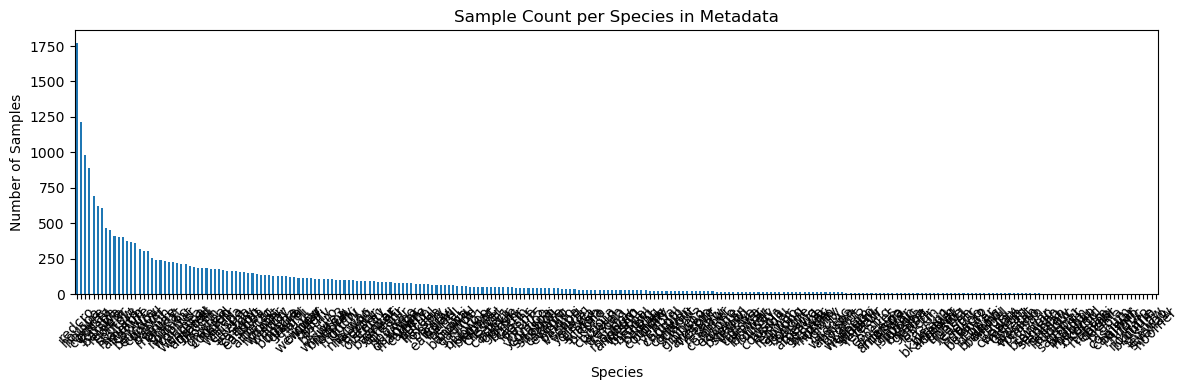

In [17]:
# Class distribution for the full dataset (OPTIONAL!)
species_counts = train_meta['ebird_code'].value_counts()

plt.figure(figsize=(12, 4))
species_counts.plot(kind='bar')
plt.title("Sample Count per Species in Metadata")
plt.xlabel("Species")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

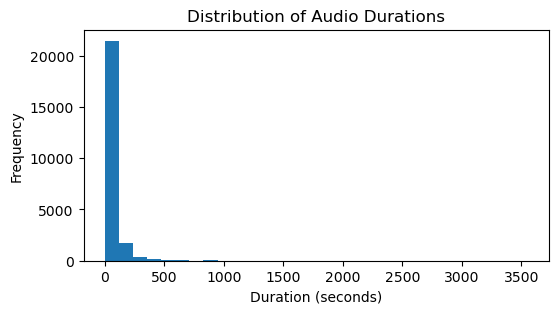

In [18]:
# Audio distribution (OPTIONAL!)
train_meta['duration'].plot(kind='hist', bins=30, figsize=(6, 3), title='Distribution of Audio Durations')
plt.xlabel("Duration (seconds)")
plt.show()

### Data Cleaning

In [19]:
# Keeping only the 12 important species used in spectrogram data
meta_clean = train_meta[train_meta['ebird_code'].isin(species_keys)]

# Removing recordings with other birds (clean secondary_labels)
meta_clean = meta_clean[meta_clean['secondary_labels'] == '[]']

# Filtering based on quality and length
meta_clean = meta_clean[
    (meta_clean['rating'] >= 3.0) &
    (meta_clean['duration'] >= 3.0) &
    (meta_clean['sampling_rate'].isin(['44100 (Hz)', '48000 (Hz)']))
]

# Dropping unnecessary and empty columns
meta_clean = meta_clean.drop(columns=['playback_used', 'bird_seen', 'background'])

# Dropping rows with missing values
meta_clean = meta_clean.dropna()

# Final shape 
print("\nFinal cleaned metadata shape:", meta_clean.shape)
meta_clean.head()


Final cleaned metadata shape: (1956, 26)


rating ebird_code    channels        date  duration      filename  \
166     5.0     amecro  2 (stereo)  2020-07-12        44  XC575220.mp3   
169     5.0     amecro  2 (stereo)  2020-06-17        41  XC569711.mp3   
171     5.0     amecro    1 (mono)  2020-06-14        78  XC568365.mp3   
173     5.0     amecro  2 (stereo)  0000-00-00        52  XC561291.mp3   
174     5.0     amecro    1 (mono)  2019-04-18        13  XC556240.mp3   

           species                                              title  \
166  American Crow     XC575220 American Crow (Corvus brachyrhynchos)   
169  American Crow  XC569711 American Crow (Corvus brachyrhynchos ...   
171  American Crow  XC568365 American Crow (Corvus brachyrhynchos ...   
173  American Crow     XC561291 American Crow (Corvus brachyrhynchos)   
174  American Crow     XC556240 American Crow (Corvus brachyrhynchos)   

    secondary_labels               sci_name  ... file_type   xc_id  \
166               []  Corvus brachyrhynchos  ...       mp3  575220   
169               []  Corvus brachyrhynchos  ...       mp3  569711   
171               []  Corvus brachyrhynchos  ...       mp3  568365   
173               []  Corvus brachyrhynchos  ...       mp3  561291   
174               []  Corvus brachyrhynchos  ...       mp3  556240   

                                   url        country          author  \
166  https://www.xeno-canto.org/575220  United States  Michael Hurben   
169  https://www.xeno-canto.org/569711  United States       Russ Wigh   
171  https://www.xeno-canto.org/568365  United States       Russ Wigh   
173  https://www.xeno-canto.org/561291  United States       Jim Berry   
174  https://www.xeno-canto.org/556240  United States      Caio Brito   

                           primary_label longitude   time       recordist  \
166  Corvus brachyrhynchos_American Crow -93.37860  06:00  Michael Hurben   
169  Corvus brachyrhynchos_American Crow -81.05590  15:00       Russ Wigh   
171  Corvus brachyrhynchos_American Crow -81.05590  07:00       Russ Wigh   
173  Corvus brachyrhynchos_American Crow -79.23810  06:00       Jim Berry   
174  Corvus brachyrhynchos_American Crow -81.40509  18:35      Caio Brito   

                                               license  
166  Creative Commons Attribution-NonCommercial-Sha...  
169  Creative Commons Attribution-NonCommercial-Sha...  
171  Creative Commons Attribution-NonCommercial-Sha...  
173  Creative Commons Attribution-NonCommercial-Sha...  
174  Creative Commons Attribution-NonCommercial-Sha...  

[5 rows x 26 columns]

### Model Preparation

### 1. Binary Classification

In [25]:
# Selecting random species for binary classification with at least 50 samples each

bin_species = [key for key in species_keys if f[key].shape[2] >= 50]
species_1, species_2 = random.sample(bin_species, 2)
print(f"\nSelected species for binary classification: {species_1} vs {species_2}")


Selected species for binary classification: bewwre vs whcspa


In [29]:
# Extracting and transposing the spectrograms (time x freq)
X1 = np.transpose(f[species_1][:], (2, 0, 1))
X2 = np.transpose(f[species_2][:], (2, 0, 1))

# Labeling the data (0 = species_1, 1 = species_2)
y1 = np.zeros(X1.shape[0])
y2 = np.ones(X2.shape[0])

# Combing labels and input data
X_binary = np.concatenate((X1, X2), axis=0)
y_binary = np.concatenate((y1, y2), axis=0)

print(f"\n{species_1} samples: {X1.shape[0]} \n{species_2} samples: {X2.shape[0]}")
print(f"Combined dataset shape: X = {X_binary.shape}, y = {y_binary.shape}")


bewwre samples: 144 
whcspa samples: 91
Combined dataset shape: X = (235, 128, 517), y = (235,)


In [30]:
# Splitting the dataset int train/test

# Shuffling the dataset
X_binary, y_binary = shuffle(X_binary, y_binary, random_state=42)

# Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

print("\nTraining set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (164, 128, 517) (164,)
Testing set shape: (71, 128, 517) (71,)


In [31]:
# Normalising the spectogram data (better for training nueral networks)

def normalize(x, eps=1e-8):
    min_val = np.min(x)
    max_val = np.max(x)
    range_val = max_val - min_val
    if range_val < eps:
        return np.zeros_like(x, dtype=np.float32)
    return ((x - min_val) / (range_val + eps)).astype(np.float32)

# Scaled the data to avoid any consequences and for better processing

X_train_norm = np.array([normalize(x) for x in X_train], dtype=np.float32)
X_test_norm = np.array([normalize(x) for x in X_test], dtype=np.float32)

print("Normalized Train (min/max):", X_train_norm.min(), ",", X_train_norm.max())
print("Normalized Test (min/max):", X_test_norm.min(), ",", X_test_norm.max())

Normalized Train (min/max): 0.0 , 1.0
Normalized Test (min/max): 0.0 , 1.0


In [32]:
# Reshaping for CNN (samples, height, width, channels)
X_train_cnn = X_train_norm[..., np.newaxis]  # shape: (N, 128, 517, 1)
X_test_cnn = X_test_norm[..., np.newaxis]

In [48]:
# Model building

# Base CNN model
binary_model_v1 = Sequential([
    Input(shape=(128, 517, 1)),                     
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Model compilation
binary_model_v1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model training
history_v1 = binary_model_v1.fit(X_train_cnn, y_train, epochs=10, batch_size=16,
                    validation_data=(X_test_cnn, y_test))

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.5532 - loss: 2.9976 - val_accuracy: 0.6197 - val_loss: 0.6704
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.5903 - loss: 0.6889 - val_accuracy: 0.6197 - val_loss: 0.6915
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.6297 - loss: 0.6808 - val_accuracy: 0.6197 - val_loss: 0.6926
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.6184 - loss: 0.6791 - val_accuracy: 0.6197 - val_loss: 0.6919
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.5500 - loss: 0.6758 - val_accuracy: 0.6197 - val_loss: 0.6913
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.6235 - loss: 0.6662 - val_accuracy: 0.6056 - val_loss: 0.6914
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.6286 - loss: 0.6452 - val_accuracy: 0.6338 - val_loss: 0.6885
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.6237 - loss: 0.6762 - val_accuracy: 0.

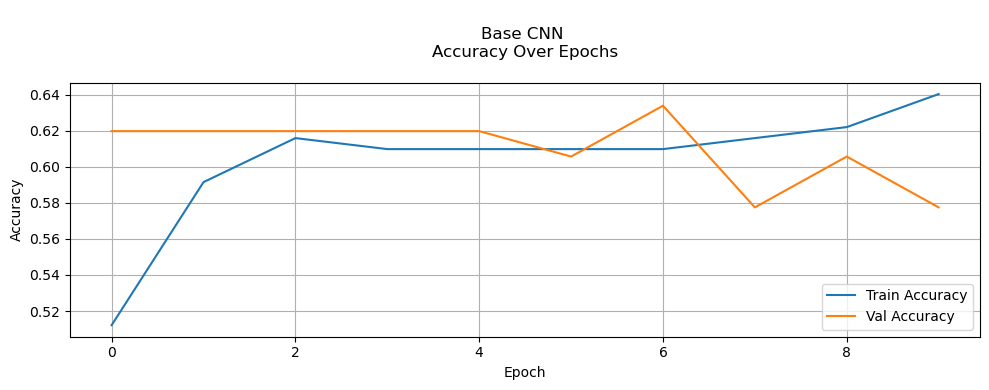

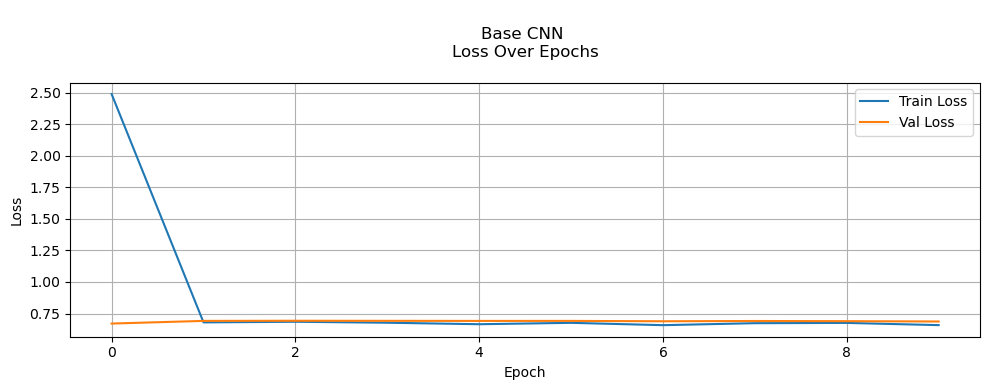

In [81]:
# Accuracy plot (for Binary v1)
plt.figure(figsize=(10, 4))
plt.plot(history_v1.history['accuracy'], label='Train Accuracy')
plt.plot(history_v1.history['val_accuracy'], label='Val Accuracy')
plt.title('\nBase CNN \nAccuracy Over Epochs\n')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot (for Binary v1)
plt.figure(figsize=(10, 4))
plt.plot(history_v1.history['loss'], label='Train Loss')
plt.plot(history_v1.history['val_loss'], label='Val Loss')
plt.title('\nBase CNN \nLoss Over Epochs\n')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


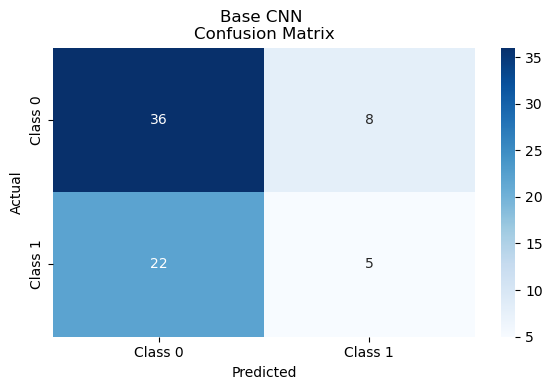

Base CNN 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.82      0.71        44
         1.0       0.38      0.19      0.25        27

    accuracy                           0.58        71
   macro avg       0.50      0.50      0.48        71
weighted avg       0.53      0.58      0.53        71



In [82]:
# Predictions and thresholds at 0.5 (Base CNN)
y_pred_prob_v1 = binary_model_v1.predict(X_test_cnn)

# Converting probabilities to binary predictions (0 or 1)
y_pred_v1 = (y_pred_prob_v1 > 0.5).astype(int).flatten()

# Confusion Matrix
cm_v1 = confusion_matrix(y_test, y_pred_v1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_v1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title("Base CNN \nConfusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report
print("Base CNN \nClassification Report:")
print(classification_report(y_test, y_pred_v1))

In [83]:
# Base CNN model performance summary
final_train_acc_v1 = history_v1.history['accuracy'][-1]
final_val_acc_v1 = history_v1.history['val_accuracy'][-1]
final_train_loss_v1 = history_v1.history['loss'][-1]
final_val_loss_v1 = history_v1.history['val_loss'][-1]

summary_df_v1 = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [f"{final_train_acc_v1:.4f}", f"{final_train_loss_v1:.4f}"],
    'Validation': [f"{final_val_acc_v1:.4f}", f"{final_val_loss_v1:.4f}"]
})

summary_df_v1

Metric Training Validation
0  Accuracy   0.6402     0.5775
1      Loss   0.6579     0.6867

In [84]:
# Deeper CNN model (more layers)
binary_model_v2 = Sequential([
    Input(shape=(128, 517, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),  
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Model compilation
binary_model_v2.compile(optimizer=Adam(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Model training
history_v2 = binary_model_v2.fit(X_train_cnn, y_train, epochs=10, batch_size=16,
                                 validation_data=(X_test_cnn, y_test))

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.4515 - loss: 1.6694 - val_accuracy: 0.6197 - val_loss: 0.6914
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5024 - loss: 0.7056 - val_accuracy: 0.6197 - val_loss: 0.6922
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.6534 - loss: 0.6838 - val_accuracy: 0.6197 - val_loss: 0.6803
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5719 - loss: 0.6813 - val_accuracy: 0.6197 - val_loss: 0.6820
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5773 - loss: 0.7267 - val_accuracy: 0.6197 - val_loss: 0.6905
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.6292 - loss: 0.6858 - val_accuracy: 0.6197 - val_loss: 0.6882
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6208 - loss: 0.6755 - val_accuracy: 0.6197 - val_loss: 0.6790
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.6241 - loss: 0.6782 - val_accuracy: 0.

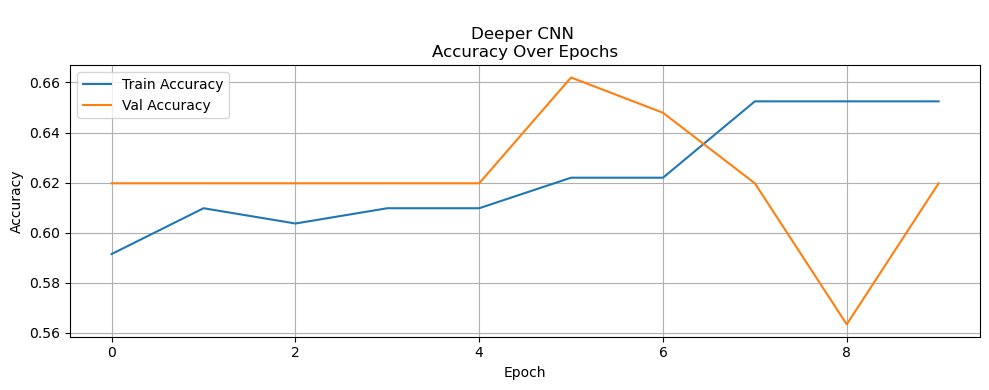

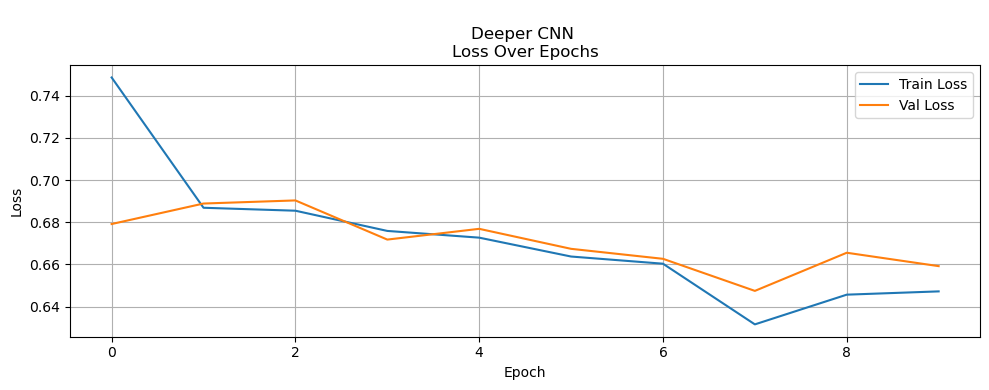

In [44]:
# Accuracy plot (for Binary v2)
plt.figure(figsize=(10, 4))
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('\nDeeper CNN \nAccuracy Over Epochs\n')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot (for Binary v2)
plt.figure(figsize=(10, 4))
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Val Loss')
plt.title('\nDeeper CNN \nLoss Over Epochs\n')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step 


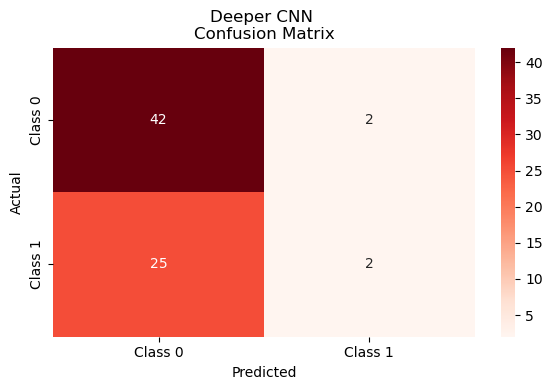

Deeper CNN 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.95      0.76        44
         1.0       0.50      0.07      0.13        27

    accuracy                           0.62        71
   macro avg       0.56      0.51      0.44        71
weighted avg       0.58      0.62      0.52        71



In [60]:
# Predictions and thresholds at 0.5 (Deeper CNN)
y_pred_prob_v2 = binary_model_v2.predict(X_test_cnn)

# Converting probabilities to binary predictions (0 or 1)
y_pred_v2 = (y_pred_prob_v2 > 0.5).astype(int).flatten()

# Confusion Matrix
cm_v2 = confusion_matrix(y_test, y_pred_v2)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title("Deeper CNN \nConfusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report
print("Deeper CNN \nClassification Report:")
print(classification_report(y_test, y_pred_v2))

In [52]:
# Deeper CNN model performance summary
final_train_acc_v2 = history_v2.history['accuracy'][-1]
final_val_acc_v2 = history_v2.history['val_accuracy'][-1]
final_train_loss_v2 = history_v2.history['loss'][-1]
final_val_loss_v2 = history_v2.history['val_loss'][-1]

summary_df_v2 = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [f"{final_train_acc_v2:.4f}", f"{final_train_loss_v2:.4f}"],
    'Validation': [f"{final_val_acc_v2:.4f}", f"{final_val_loss_v2:.4f}"]
})

summary_df_v2

Metric Training Validation
0  Accuracy   0.6524     0.6197
1      Loss   0.6472     0.6592

In [35]:
# Lighter CNN model (fewer layers)
binary_model_v3 = Sequential([
    Input(shape=(128, 517, 1)),
    Conv2D(8, (3, 3), activation='relu'),  
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Model compilation
binary_model_v3.compile(optimizer='adamax',  
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Model training
history_v3 = binary_model_v3.fit(X_train_cnn, y_train, epochs=10, batch_size=16,
                                 validation_data=(X_test_cnn, y_test))

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.5740 - loss: 0.7543 - val_accuracy: 0.4648 - val_loss: 0.6838
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6312 - loss: 0.6459 - val_accuracy: 0.6620 - val_loss: 0.6334
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6890 - loss: 0.6427 - val_accuracy: 0.6620 - val_loss: 0.6290
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6660 - loss: 0.6017 - val_accuracy: 0.6620 - val_loss: 0.6227
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7142 - loss: 0.5905 - val_accuracy: 0.6620 - val_loss: 0.6183
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7194 - loss: 0.5556 - val_accuracy: 0.7042 - val_loss: 0.6057
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7051 - loss: 0.5481 - val_accuracy: 0.7324 - val_loss: 0.6010
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7994 - loss: 0.5152 - val_accuracy: 0.7606 - 

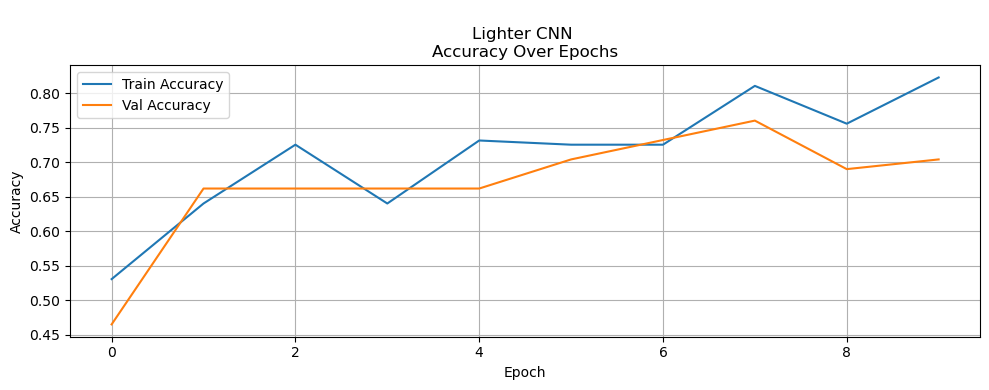

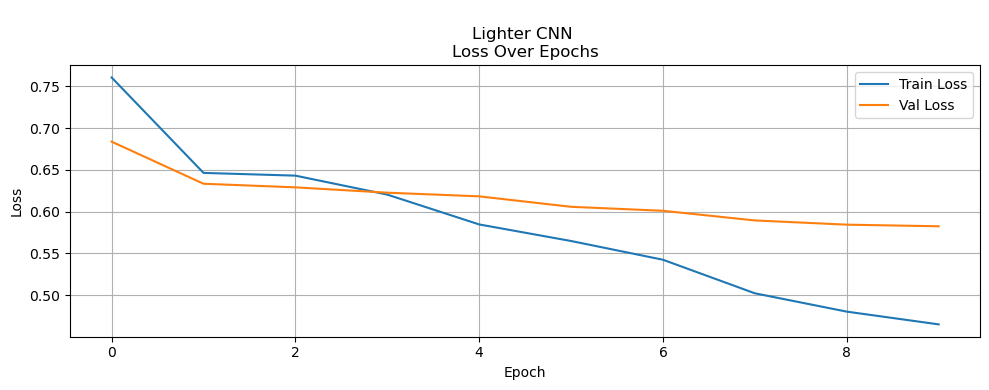

In [ ]:
# Accuracy plot (for Binary v2)
plt.figure(figsize=(10, 4))
plt.plot(history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Val Accuracy')
plt.title('\nLighter CNN \nAccuracy Over Epochs\n')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot (for Binary v2)
plt.figure(figsize=(10, 4))
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Val Loss')
plt.title('\nLighter CNN \nLoss Over Epochs\n')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


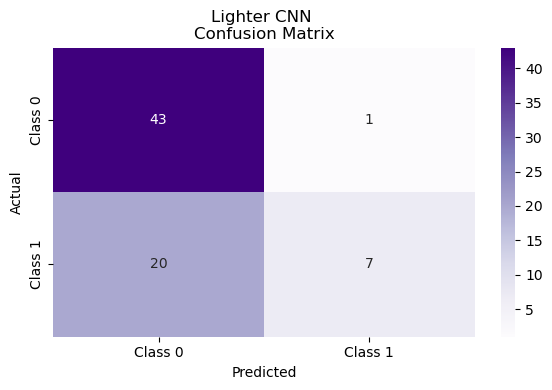

Lighter CNN 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80        44
         1.0       0.88      0.26      0.40        27

    accuracy                           0.70        71
   macro avg       0.78      0.62      0.60        71
weighted avg       0.76      0.70      0.65        71



In [63]:
# Predictions and thresholds at 0.5 (Lighter CNN)
y_pred_prob_v3 = binary_model_v3.predict(X_test_cnn)

# Converting probabilities to binary predictions (0 or 1)
y_pred_v3 = (y_pred_prob_v3 > 0.5).astype(int).flatten()

# Confusion Matrix
cm_v3 = confusion_matrix(y_test, y_pred_v3)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_v3, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title("Lighter CNN \nConfusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report
print("Lighter CNN \nClassification Report:")
print(classification_report(y_test, y_pred_v3))

In [53]:
# Lighter CNN model performance summary
final_train_acc_v3 = history_v3.history['accuracy'][-1]
final_val_acc_v3 = history_v3.history['val_accuracy'][-1]
final_train_loss_v3 = history_v3.history['loss'][-1]
final_val_loss_v3 = history_v3.history['val_loss'][-1]

summary_df_v3 = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [f"{final_train_acc_v3:.4f}", f"{final_train_loss_v3:.4f}"],
    'Validation': [f"{final_val_acc_v3:.4f}", f"{final_val_loss_v3:.4f}"]
})

summary_df_v3

Metric Training Validation
0  Accuracy   0.8232     0.7042
1      Loss   0.4649     0.5824

In [94]:
# OPTIONAL!
# Combined model performance summary (all models) 
combined_summary_df = pd.DataFrame({
    'Model': ['Base CNN', 'Deeper CNN', 'Lighter CNN'],
    'Train Accuracy': [final_train_acc_v1, final_train_acc_v2, final_train_acc_v3],
    'Val Accuracy': [final_val_acc_v1, final_val_acc_v2, final_val_acc_v3],
    'Train Loss': [final_train_loss_v1, final_train_loss_v2, final_train_loss_v3],
    'Val Loss': [final_val_loss_v1, final_val_loss_v2, final_val_loss_v3],
})

combined_summary_df.style.format({
    "Train Accuracy": "{:.4f}",
    "Val Accuracy": "{:.4f}",
    "Train Loss": "{:.4f}",
    "Val Loss": "{:.4f}"
})

In [93]:
# Converting model summary into % (OPTIONAL!)
combined_summary_df.style.format({
    "Train Accuracy": "{:.2%}",
    "Val Accuracy": "{:.2%}",
    "Train Loss": "{:.4f}",
    "Val Loss": "{:.4f}"
}).set_caption("Combined Model Performance Summary (%)")

In [89]:
# Combining all models' classification reports (OPTIONAL!)

def all_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Collecting metrics for each model
results = [
    all_metrics(y_test, y_pred_v1, 'Base CNN (v1)'),
    all_metrics(y_test, y_pred_v2, 'Deeper CNN (v2)'),
    all_metrics(y_test, y_pred_v3, 'Lighter CNN (v3)')
]

# Convert to DataFrame
combined_report_df = pd.DataFrame(results)
combined_report_df

Model  Accuracy  Precision    Recall  F1-Score
0     Base CNN (v1)  0.577465   0.530915  0.577465  0.532519
1   Deeper CNN (v2)  0.619718   0.578621  0.619718  0.518045
2  Lighter CNN (v3)  0.704225   0.755729  0.704225  0.650204

Comment:
- The base and deeper CNNs showed moderate performance, but the lighter CNN (v3) clearly outperformed both, achieving the highest accuracy (70.42%) and F1-score (65.02%). 

This indicates that a simpler architecture was more effective for binary classification, likely due to better generalization and reduced overfitting on limited data.

In [91]:
# Converting combined classification report to % (OPTIONAL!!)

combined_report_df.style.format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.2%}",
    "Recall": "{:.2%}",
    "F1-Score": "{:.2%}"
}).set_caption("Combined Classification Report (%)")

Comment:
- The lighter CNN (v3) performed best overall with the highest accuracy (70.42%) and F1-score (65.02%), showing strong generalization between the two selected bird species. The deeper model (v2) slightly improved over the base (v1), but was still outperformed by the simpler model.
- This suggests that for binary classification, a lighter architecture was more efficient and effective.

### 2. Multi-Class Classification

In [76]:
X_multi = []
y_multi = []
label_map = {}

# Looping through all the 12 species
for i, species in enumerate(species_keys):
    # Load and convert to float32 immediately
    spectrograms = f[species][:].astype(np.float32)  
    num_samples = spectrograms.shape[2]

    for j in range(num_samples):
        X_multi.append(spectrograms[:, :, j])  
        y_multi.append(i)

    label_map[species] = i

# Converting lists to numpy arrays
X_multi = np.array(X_multi, dtype=np.float32)
y_multi = np.array(y_multi)

print("X_multi shape:", X_multi.shape)
print("y_multi shape:", y_multi.shape)
print("\nLabel mapping:", label_map)

X_multi shape: (1981, 128, 517)
y_multi shape: (1981,)

Label mapping: {'amecro': 0, 'amerob': 1, 'bewwre': 2, 'bkcchi': 3, 'daejun': 4, 'houfin': 5, 'houspa': 6, 'norfli': 7, 'rewbla': 8, 'sonspa': 9, 'spotow': 10, 'whcspa': 11}


In [77]:
# Splitting the dataset int train/test

# Shuffling the dataset
X_multi, y_multi = shuffle(X_multi, y_multi, random_state=42)

# Train-test split (70/30)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi)

# Normalizing each spectrogram sample to [0, 1]
epsilon = 1e-8  # constant to prevent divide-by-zero

X_train_m_norm = np.array([
    (x - np.min(x)) / (np.max(x) - np.min(x) + epsilon) for x in X_train_m])

X_test_m_norm = np.array([
    (x - np.min(x)) / (np.max(x) - np.min(x) + epsilon) for x in X_test_m])

# Reshaping for CNN input
X_train_m_cnn = X_train_m_norm[..., np.newaxis]
X_test_m_cnn = X_test_m_norm[..., np.newaxis]

print("Training set shape:", X_train_m_cnn.shape)
print("Testing set shape:", X_test_m_cnn.shape)

Training set shape: (1386, 128, 517, 1)
Testing set shape: (595, 128, 517, 1)


In [106]:
# Computing class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_m),
    y=y_train_m
)
class_weights = dict(enumerate(class_weights)) 

In [ ]:
# Model building
# Building the Base CNN model
multi_model_v1 = Sequential([
    Input(shape=(128, 517, 1)),

    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Fully Connected
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(12, activation='softmax')])

# Model compilation
multi_model_v1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history_multi_v1 = multi_model_v1.fit(
    X_train_m_cnn, y_train_m,
    validation_data=(X_test_m_cnn, y_test_m),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.0688 - loss: 28.5379 - val_accuracy: 0.0891 - val_loss: 57.7733
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.0548 - loss: 2.5398 - val_accuracy: 0.0185 - val_loss: 45.4698
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.0447 - loss: 2.5264 - val_accuracy: 0.0723 - val_loss: 42.3091
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.0626 - loss: 2.4343 - val_accuracy: 0.0672 - val_loss: 27.9418
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.0479 - loss: 2.4625 - val_accuracy: 0.1294 - val_loss: 23.9226
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.0352 - loss: 2.4494 - val_accuracy: 0.1311 - val_loss: 20.0926
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.0275 - loss: 2.5294 - val_accuracy: 0.1311 - val_loss: 14.0483
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.0290 - loss: 2.4981 - val_accuracy: 0.

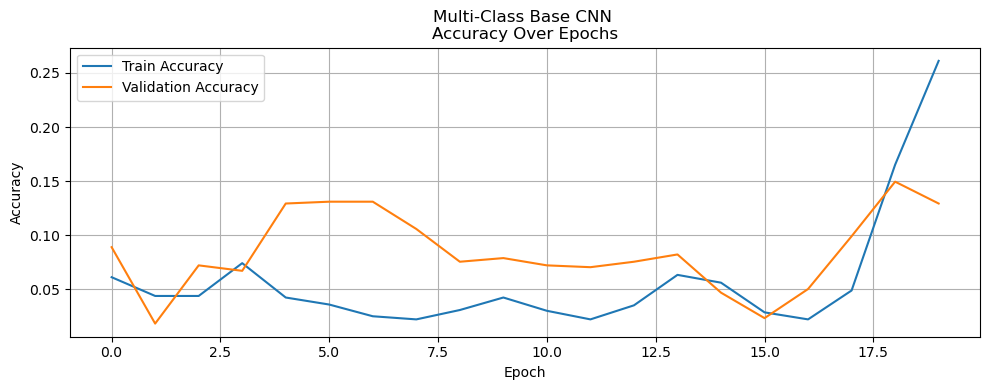

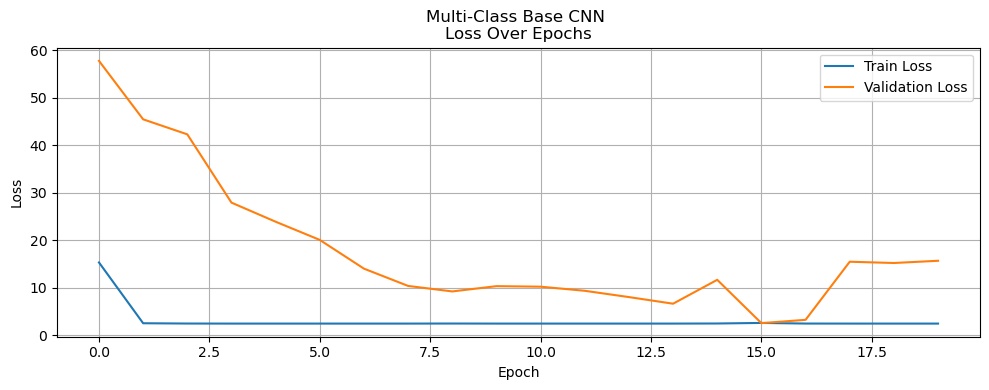

In [98]:
# Accuracy plot for Base CNN (Multi-Class)

plt.figure(figsize=(10, 4))
plt.plot(history_multi_v1.history['accuracy'], label='Train Accuracy')
plt.plot(history_multi_v1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi-Class Base CNN \nAccuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot for Base CNN (Multi-Class)
plt.figure(figsize=(10, 4))
plt.plot(history_multi_v1.history['loss'], label='Train Loss')
plt.plot(history_multi_v1.history['val_loss'], label='Validation Loss')
plt.title('Multi-Class Base CNN \nLoss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
# Predicting class probabilities
y_pred_probs = multi_model_v1.predict(X_test_m_cnn)

# Converting to class labels (index of max prob)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step


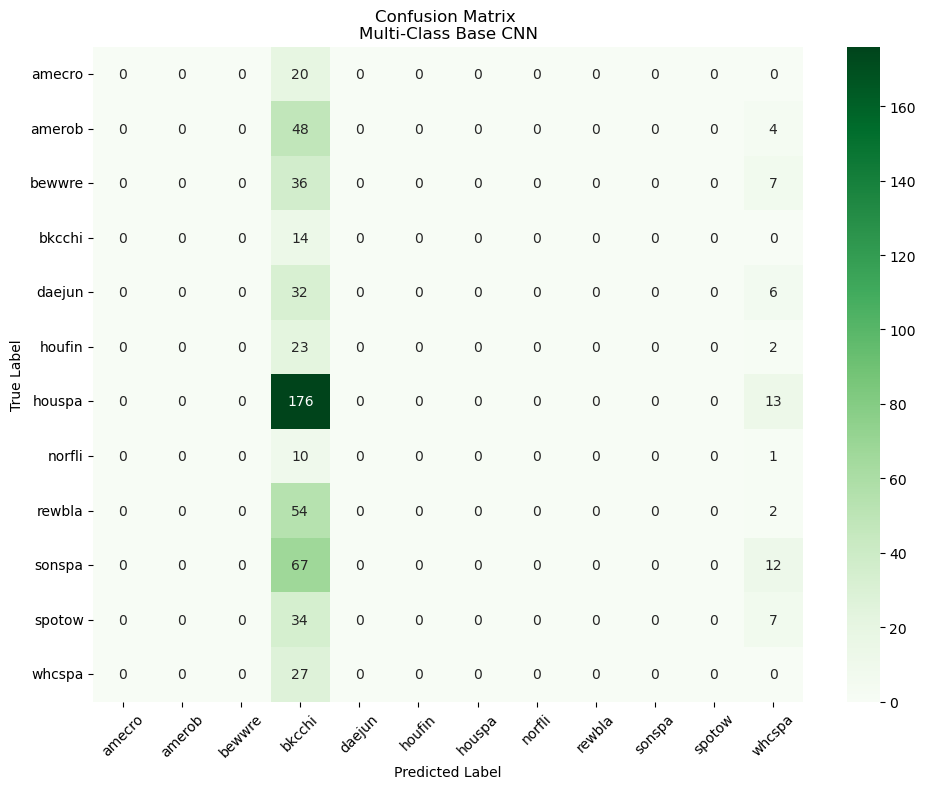

Classification Report:

              precision    recall  f1-score   support

      amecro       0.00      0.00      0.00        20
      amerob       0.00      0.00      0.00        52
      bewwre       0.00      0.00      0.00        43
      bkcchi       0.03      1.00      0.05        14
      daejun       0.00      0.00      0.00        38
      houfin       0.00      0.00      0.00        25
      houspa       0.00      0.00      0.00       189
      norfli       0.00      0.00      0.00        11
      rewbla       0.00      0.00      0.00        56
      sonspa       0.00      0.00      0.00        79
      spotow       0.00      0.00      0.00        41
      whcspa       0.00      0.00      0.00        27

    accuracy                           0.02       595
   macro avg       0.00      0.08      0.00       595
weighted avg       0.00      0.02      0.00       595



In [103]:
# Confusion Matrix for Multi-Class Base CNN
cm_v1 = confusion_matrix(y_test_m, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_v1, annot=True, fmt='d', cmap='Greens', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix \nMulti-Class Base CNN')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test_m, y_pred_classes, target_names=label_map.keys(), zero_division=0 ))

# Used zero_division=0 to avoid division-by-zero warnings

In [104]:
# Summary for model performance for Multi-Class Base CNN
final_train_acc = history_multi_v1.history['accuracy'][-1]
final_val_acc = history_multi_v1.history['val_accuracy'][-1]
final_train_loss = history_multi_v1.history['loss'][-1]
final_val_loss = history_multi_v1.history['val_loss'][-1]

summary_multi_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [f"{final_train_acc:.4f}", f"{final_train_loss:.4f}"],
    'Validation': [f"{final_val_acc:.4f}", f"{final_val_loss:.4f}"]
})

summary_multi_df

Metric Training Validation
0  Accuracy   0.2612     0.1294
1      Loss   2.4851    15.7044

In [107]:
# Building the Deeper Multi-Class CNN model
multi_model_v2 = Sequential([
    Input(shape=(128, 517, 1)),

    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Conv Block 4 (Extra layer for depth)
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Fully Connected
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(12, activation='softmax')
])

# Model compilation
multi_model_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training
history_multi_v2 = multi_model_v2.fit(
    X_train_m_cnn, y_train_m,
    validation_data=(X_test_m_cnn, y_test_m),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.1123 - loss: 24.1778 - val_accuracy: 0.0454 - val_loss: 9.4523
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.0911 - loss: 3.1516 - val_accuracy: 0.1328 - val_loss: 28.1477
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.0422 - loss: 2.4848 - val_accuracy: 0.1328 - val_loss: 30.3764
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.0422 - loss: 2.4935 - val_accuracy: 0.1328 - val_loss: 31.9681
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.0488 - loss: 2.5543 - val_accuracy: 0.1328 - val_loss: 31.0926


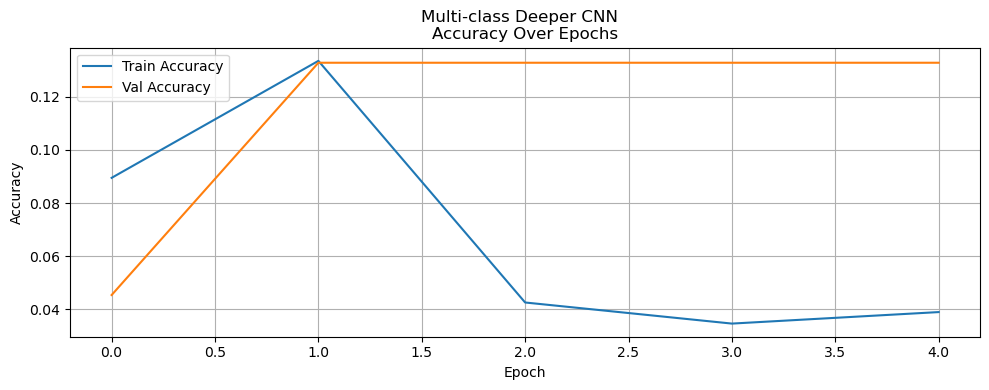

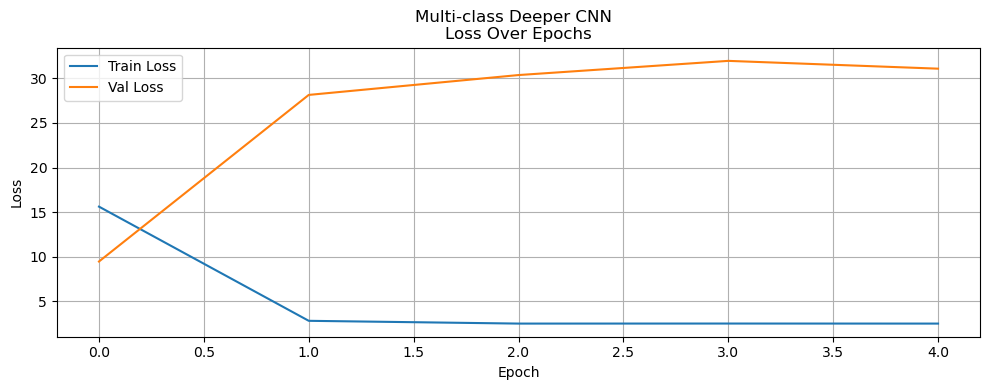

In [108]:
# Accuracy plot for Multi-Class Deeper CNN
plt.figure(figsize=(10, 4))
plt.plot(history_multi_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_multi_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('Multi-class Deeper CNN  \nAccuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot for Multi-Class Deeper CNN
plt.figure(figsize=(10, 4))
plt.plot(history_multi_v2.history['loss'], label='Train Loss')
plt.plot(history_multi_v2.history['val_loss'], label='Val Loss')
plt.title('Multi-class Deeper CNN  \nLoss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step


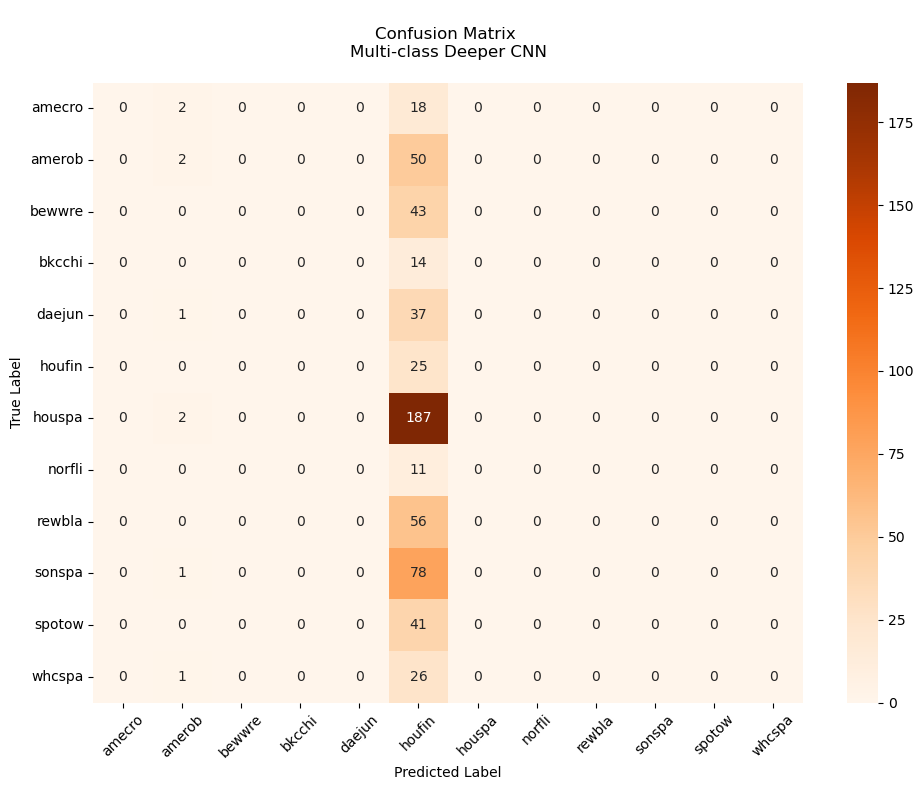

Multi-class Deeper CNN  
Classification Report:

              precision    recall  f1-score   support

      amecro       0.00      0.00      0.00        20
      amerob       0.22      0.04      0.07        52
      bewwre       0.00      0.00      0.00        43
      bkcchi       0.00      0.00      0.00        14
      daejun       0.00      0.00      0.00        38
      houfin       0.04      1.00      0.08        25
      houspa       0.00      0.00      0.00       189
      norfli       0.00      0.00      0.00        11
      rewbla       0.00      0.00      0.00        56
      sonspa       0.00      0.00      0.00        79
      spotow       0.00      0.00      0.00        41
      whcspa       0.00      0.00      0.00        27

    accuracy                           0.05       595
   macro avg       0.02      0.09      0.01       595
weighted avg       0.02      0.05      0.01       595



In [133]:
# Predicting class probabilities
y_pred_probs_v2 = multi_model_v2.predict(X_test_m_cnn)
y_pred_classes_v2 = np.argmax(y_pred_probs_v2, axis=1)

# Confusion matrix
cm_v2 = confusion_matrix(y_test_m, y_pred_classes_v2)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Oranges',  
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('\nConfusion Matrix \nMulti-class Deeper CNN\n')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("Multi-class Deeper CNN  \nClassification Report:\n")
print(classification_report(
    y_test_m, y_pred_classes_v2,
    target_names=label_map.keys(),
    zero_division=0
))

In [112]:
# Summary for model performance for Multi-Class Deeper CNN
final_train_acc = history_multi_v2.history['accuracy'][-1]
final_val_acc = history_multi_v2.history['val_accuracy'][-1]
final_train_loss = history_multi_v2.history['loss'][-1]
final_val_loss = history_multi_v2.history['val_loss'][-1]

summary_multi_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [f"{final_train_acc:.4f}", f"{final_train_loss:.4f}"],
    'Validation': [f"{final_val_acc:.4f}", f"{final_val_loss:.4f}"]
})

summary_multi_df

Metric Training Validation
0  Accuracy   0.0390     0.1328
1      Loss   2.4851    31.0926

In [113]:
# Building the Lighter Multi-Class Lighter CNN model 
multi_model_v3 = Sequential([
    Input(shape=(128, 517, 1)),

    # Conv Block 1
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Conv Block 2
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Fully Connected
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(12, activation='softmax')
])

# Model compilation
multi_model_v3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training
history_multi_v3 = multi_model_v3.fit(
    X_train_m_cnn, y_train_m,
    validation_data=(X_test_m_cnn, y_test_m),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.0731 - loss: 3.8112 - val_accuracy: 0.1193 - val_loss: 2.4851
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 327ms/step - accuracy: 0.0922 - loss: 2.4537 - val_accuracy: 0.0689 - val_loss: 2.4846
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 317ms/step - accuracy: 0.0843 - loss: 2.4732 - val_accuracy: 0.0723 - val_loss: 2.4849
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 315ms/step - accuracy: 0.0656 - loss: 2.4062 - val_accuracy: 0.0773 - val_loss: 2.4850
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 312ms/step - accuracy: 0.0790 - loss: 2.4903 - val_accuracy: 0.1193 - val_loss: 2.4838
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 317ms/step - accuracy: 0.0812 - loss: 2.4265 - val_accuracy: 0.1445 - val_loss: 2.4758
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 316ms/step - accuracy: 0.1089 - loss: 2.4074 - val_accuracy: 0.1462 - val_loss: 2.4781
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - accuracy: 0.0847 - loss: 2.4773 - val_accu

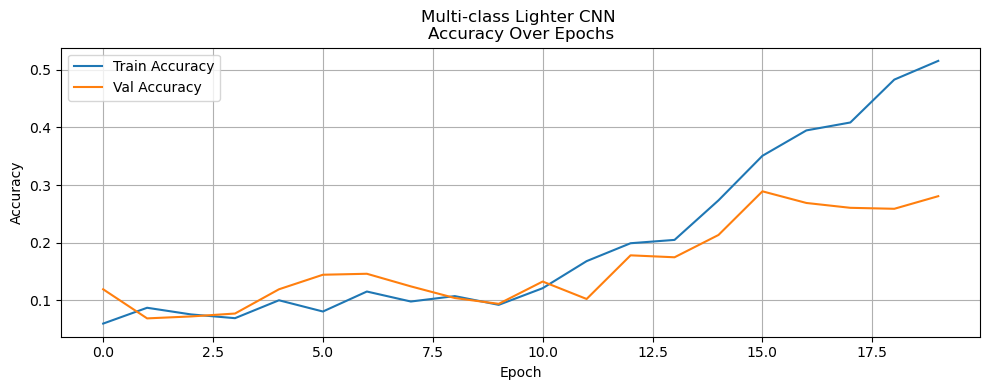

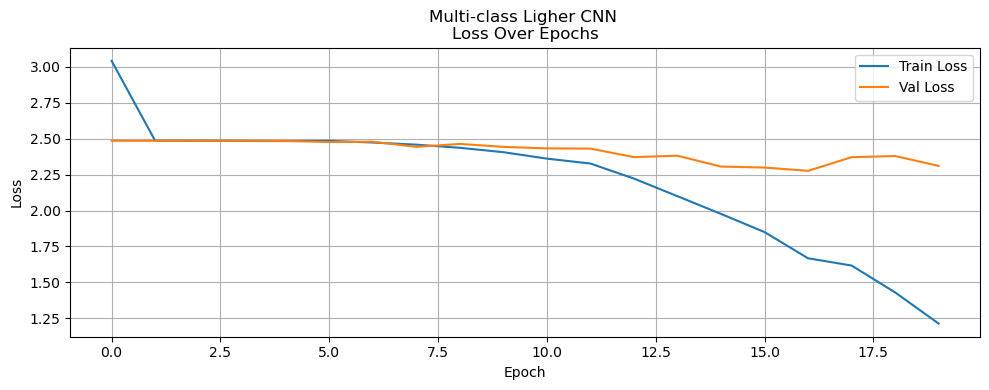

In [114]:
# Accuracy plot for Multi-Class Lighter CNN
plt.figure(figsize=(10, 4))
plt.plot(history_multi_v3.history['accuracy'], label='Train Accuracy')
plt.plot(history_multi_v3.history['val_accuracy'], label='Val Accuracy')
plt.title('Multi-class Lighter CNN \nAccuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot for Multi-Class Lighter CNN
plt.figure(figsize=(10, 4))
plt.plot(history_multi_v3.history['loss'], label='Train Loss')
plt.plot(history_multi_v3.history['val_loss'], label='Val Loss')
plt.title('Multi-class Ligher CNN \nLoss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


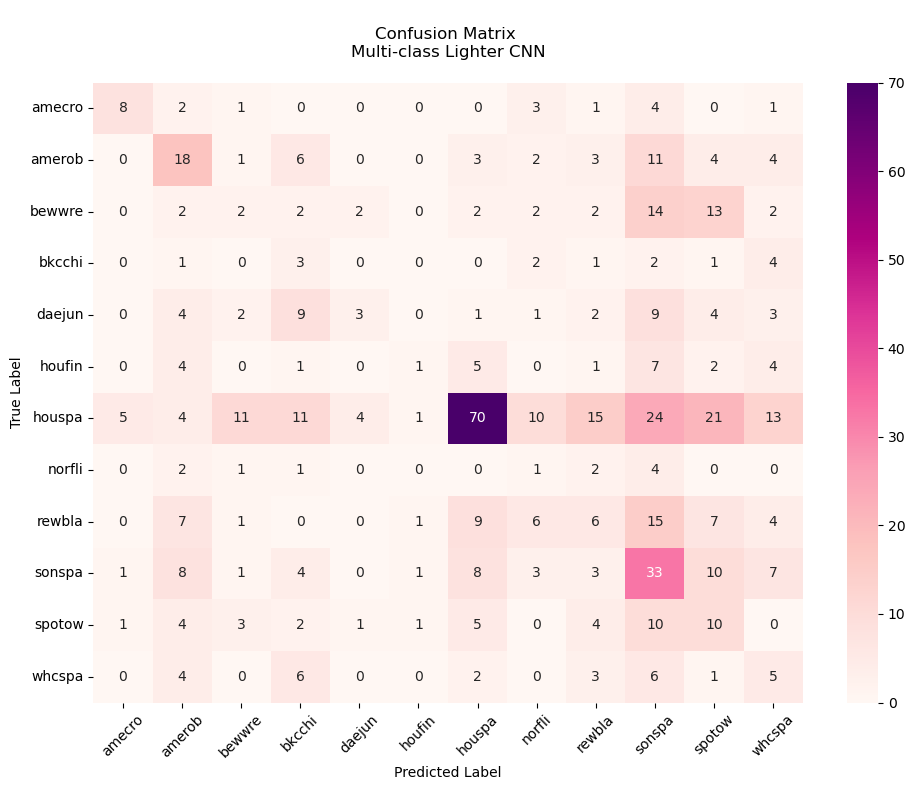

Multi-class Lighter CNN 
Classification Report:

              precision    recall  f1-score   support

      amecro       0.53      0.40      0.46        20
      amerob       0.30      0.35      0.32        52
      bewwre       0.09      0.05      0.06        43
      bkcchi       0.07      0.21      0.10        14
      daejun       0.30      0.08      0.12        38
      houfin       0.20      0.04      0.07        25
      houspa       0.67      0.37      0.48       189
      norfli       0.03      0.09      0.05        11
      rewbla       0.14      0.11      0.12        56
      sonspa       0.24      0.42      0.30        79
      spotow       0.14      0.24      0.18        41
      whcspa       0.11      0.19      0.14        27

    accuracy                           0.27       595
   macro avg       0.23      0.21      0.20       595
weighted avg       0.35      0.27      0.28       595



In [136]:
# Predicting class probabilities
y_pred_probs_v3 = multi_model_v3.predict(X_test_m_cnn)
y_pred_classes_v3 = np.argmax(y_pred_probs_v3, axis=1)

# Confusion matrix
cm_v3 = confusion_matrix(y_test_m, y_pred_classes_v3)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_v3, annot=True, fmt='d', cmap='RdPu',  
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('\nConfusion Matrix \nMulti-class Lighter CNN\n')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("Multi-class Lighter CNN \nClassification Report:\n")
print(classification_report(
    y_test_m, y_pred_classes_v3,
    target_names=label_map.keys(),
    zero_division=0
))

In [137]:
# Summary for model performance for Multi-Class Lighter CNN
final_train_acc = history_multi_v3.history['accuracy'][-1]
final_val_acc = history_multi_v3.history['val_accuracy'][-1]
final_train_loss = history_multi_v3.history['loss'][-1]
final_val_loss = history_multi_v3.history['val_loss'][-1]

summary_multi_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Training': [f"{final_train_acc:.4f}", f"{final_train_loss:.4f}"],
    'Validation': [f"{final_val_acc:.4f}", f"{final_val_loss:.4f}"]
})

summary_multi_df

Metric Training Validation
0  Accuracy   0.5152     0.2807
1      Loss   1.2137     2.3100

In [ ]:
# Combining all models' performance summary (OPTIONAL!)
# Extracting overall metrics
def extract_multi_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    return {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    }

# Collecting all metrics
multi_results = [
    extract_multi_metrics(y_test_m, y_pred_classes, 'Multi-class Base CNN'),
    extract_multi_metrics(y_test_m, y_pred_classes_v2, 'Multi-class Deeper CNN'),
    extract_multi_metrics(y_test_m, y_pred_classes_v3, 'Multi-class Lighter CNN')
]

multi_summary_df = pd.DataFrame(multi_results)

# Converting model summary into % (OPTIONAL!)
multi_summary_df.style.format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.2%}",
    "Recall": "{:.2%}",
    "F1-Score": "{:.2%}"
}).set_caption("Combined Model Performance Summary (%)")

Comment:
- The base and deeper CNNs showed very low accuracy and F1-scores, indicating poor generalization.
- The lighter CNN clearly outperformed both, achieving the highest accuracy (26.89%) and F1-score (28.30%), suggesting that simpler models can perform better in cases of class imbalance and limited data.
- This supports the conclusion that added depth did not help, while a leaner architecture was more robust.

In [ ]:
# Extracting class-wise metrics (OPTIONAL!)
def get_classification_df(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df = pd.DataFrame(report).transpose()
    df['Model'] = model_name
    df = df.reset_index().rename(columns={'index': 'Class'})
    return df[df['Class'].isin(map(str, range(12)))]  # Only keep actual class rows

# Class-wise reports for each model
df_v1 = get_classification_df(y_test_m, y_pred_classes, 'Base CNN')
df_v2 = get_classification_df(y_test_m, y_pred_classes_v2, 'Deeper CNN')
df_v3 = get_classification_df(y_test_m, y_pred_classes_v3, 'Lighter CNN')

# Combining all into one DataFrame
combined_class_report = pd.concat([df_v1, df_v2, df_v3], axis=0)


# Converting to %
combined_class_report.style.format({
    'precision': '{:.2%}',
    'recall': '{:.2%}',
    'f1-score': '{:.2%}',
    'support': '{:.0f}'
}).set_caption("Combined Multi-Class CNN Classification Report (per class in %)")

Comment:
- The base and deeper models performed poorly, with many classes showing 0% precision and recall, indicating they failed to learn meaningful patterns. In contrast, the lighter CNN model achieved better scores across most classes, especially class 0, 1, 6, and 9, suggesting that a simpler architecture was more effective in handling class imbalance and limited training data.
- This shows that deeper models may overfit or struggle with noisy, imbalanced data.

#### Converting test audio files to spectograms

Mel spectrogram shape: (128, 517) 



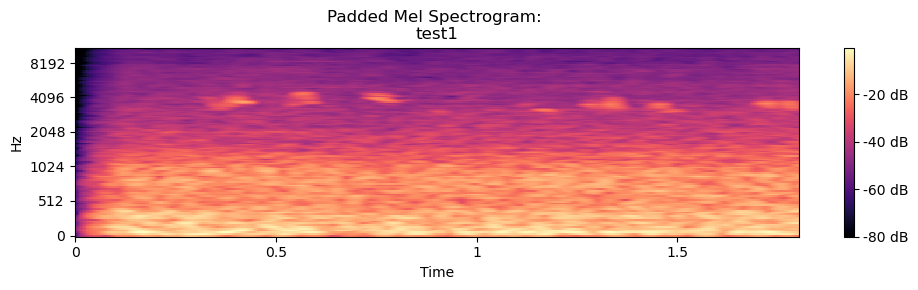

In [151]:
# Test1

# Loading the audio file
file_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\test_audio\test1_audio.wav"
audio, sr = librosa.load(file_path, sr=22050)

# Cropping to exactly 2 seconds of audio (44100 samples)
desired_len = 2 * sr
audio = audio[:desired_len] if len(audio) >= desired_len else np.pad(audio, (0, desired_len - len(audio)))

# Mel spectrogram
n_fft = 2048
hop_length = 77  
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Padding the spectogram
def pad_spectrogram(spec, target_width=517):
    current_width = spec.shape[1]
    if current_width < target_width:
        padding_width = target_width - current_width
        spec = np.pad(spec, ((0, 0), (0, padding_width)), mode='constant')
    elif current_width > target_width:
        spec = spec[:, :target_width]
    return spec

mel_spec_db_fixed = pad_spectrogram(mel_spec_db)

print("Mel spectrogram shape:", mel_spec_db_fixed.shape, "\n")

# Plot
plt.figure(figsize=(10, 3))
librosa.display.specshow(mel_spec_db_fixed, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title("Padded Mel Spectrogram: \ntest1")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

spec1 = mel_spec                 # Later used for normalisation

##### Prediction for *test1* 

In [152]:
# Normalizing the spectrogram
spec1_norm = (mel_spec_db_fixed - np.min(mel_spec_db_fixed)) / (np.max(mel_spec_db_fixed) - np.min(mel_spec_db_fixed) + 1e-8)

# Reshape to match model input shape
spec1_input = spec1_norm[np.newaxis, ..., np.newaxis]  # Shape: (1, 128, 517, 1)

# Predicting
pred_probs = multi_model_v3.predict(spec1_input)[0]
pred_index = np.argmax(pred_probs)
pred_species = list(label_map.keys())[list(label_map.values()).index(pred_index)]

# Top-3 predictions
top3_indices = pred_probs.argsort()[-3:][::-1]
top3_species = [list(label_map.keys())[list(label_map.values()).index(i)] for i in top3_indices]
top3_probs = [pred_probs[i] for i in top3_indices]

# Output
print(f"\nPrediction for Test1:")
print(f"Top prediction: {pred_species} ({pred_probs[pred_index]*100:.2f}%)")
print("Top 3 predictions:")
for sp, pr in zip(top3_species, top3_probs):
    print(f"- {sp}: {pr*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step

Prediction for Test1:
Top prediction: norfli (11.87%)
Top 3 predictions:
- norfli: 11.87%
- amerob: 11.06%
- bkcchi: 10.18%


Mel spectrogram shape: (128, 517) 



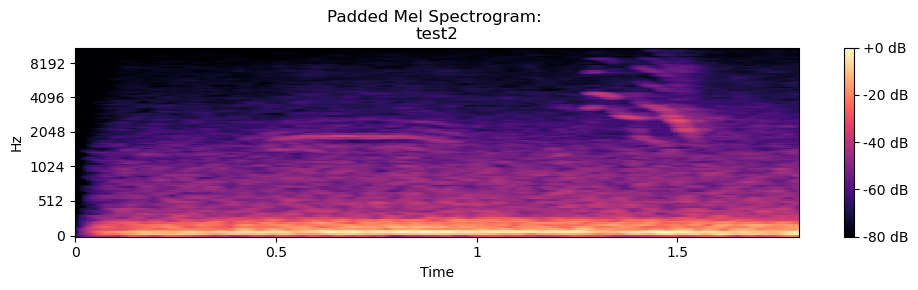

In [163]:
# Test2

# Loading the audio file
file_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\test_audio\test2_audio.wav"
audio, sr = librosa.load(file_path, sr=22050)

# Cropping to exactly 2 seconds of audio (44100 samples)
desired_len = 2 * sr
audio = audio[:desired_len] if len(audio) >= desired_len else np.pad(audio, (0, desired_len - len(audio)))

# Mel spectrogram
n_fft = 2048
hop_length = 77  
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Padding the spectogram
def pad_spectrogram(spec, target_width=517):
    current_width = spec.shape[1]
    if current_width < target_width:
        padding_width = target_width - current_width
        spec = np.pad(spec, ((0, 0), (0, padding_width)), mode='constant')
    elif current_width > target_width:
        spec = spec[:, :target_width]
    return spec

mel_spec_db_fixed = pad_spectrogram(mel_spec_db)

print("Mel spectrogram shape:", mel_spec_db_fixed.shape, "\n")

# Plot
plt.figure(figsize=(10, 3))
librosa.display.specshow(mel_spec_db_fixed, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title("Padded Mel Spectrogram: \ntest2")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

spec2 = mel_spec                 # Later used for normalisation

##### Prediction for *test2*

In [164]:
# Normalizing the spectrogram
spec2_norm = (mel_spec_db_fixed - np.min(mel_spec_db_fixed)) / (np.max(mel_spec_db_fixed) - np.min(mel_spec_db_fixed) + 1e-8)

# Reshape to match model input shape
spec2_input = spec2_norm[np.newaxis, ..., np.newaxis]  # Shape: (1, 128, 517, 1)

# Predicting
pred_probs2 = multi_model_v3.predict(spec2_input)[0]
pred_index2 = np.argmax(pred_probs2)
pred_species2 = list(label_map.keys())[list(label_map.values()).index(pred_index2)]

# Top-3 predictions
top3_indices2 = pred_probs2.argsort()[-3:][::-1]
top3_species2 = [list(label_map.keys())[list(label_map.values()).index(i)] for i in top3_indices2]
top3_probs2 = [pred_probs2[i] for i in top3_indices2]

# Output
print(f"\nPrediction for Test2:")
print(f"Top prediction: {pred_species2} ({pred_probs2[pred_index2]*100:.2f}%)")
print("Top 3 predictions:")
for sp, pr in zip(top3_species2, top3_probs2):
    print(f"- {sp}: {pr*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Prediction for Test2:
Top prediction: rewbla (31.79%)
Top 3 predictions:
- rewbla: 31.79%
- whcspa: 20.49%
- houspa: 19.30%


Mel spectrogram shape: (128, 517) 



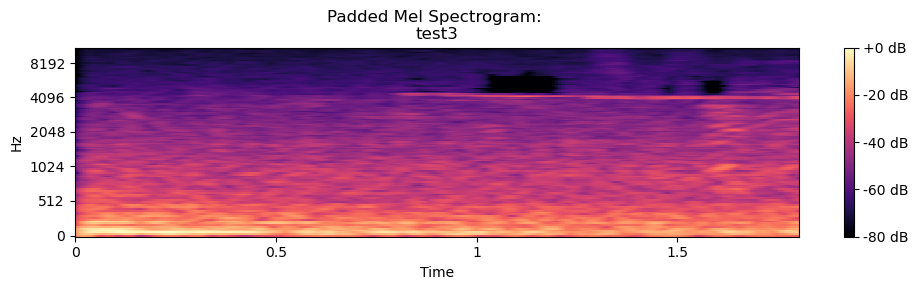

In [166]:
# Test3

# Loading the audio file
file_path = r"C:\Users\mehek\OneDrive\Desktop\STML 3\test_audio\test3_audio.wav"
audio, sr = librosa.load(file_path, sr=22050)

# Cropping to exactly 2 seconds of audio (44100 samples)
desired_len = 2 * sr
audio = audio[:desired_len] if len(audio) >= desired_len else np.pad(audio, (0, desired_len - len(audio)))

# Mel spectrogram
n_fft = 2048
hop_length = 77  
mel_spec = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Padding the spectogram
def pad_spectrogram(spec, target_width=517):
    current_width = spec.shape[1]
    if current_width < target_width:
        padding_width = target_width - current_width
        spec = np.pad(spec, ((0, 0), (0, padding_width)), mode='constant')
    elif current_width > target_width:
        spec = spec[:, :target_width]
    return spec

mel_spec_db_fixed = pad_spectrogram(mel_spec_db)

print("Mel spectrogram shape:", mel_spec_db_fixed.shape, "\n")

# Plot
plt.figure(figsize=(10, 3))
librosa.display.specshow(mel_spec_db_fixed, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title("Padded Mel Spectrogram: \ntest3")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

spec3 = mel_spec                 # Later used for normalisation

##### Prediction for *test3*

In [167]:
# Normalizing the spectrogram
spec3_norm = (mel_spec_db_fixed - np.min(mel_spec_db_fixed)) / (np.max(mel_spec_db_fixed) - np.min(mel_spec_db_fixed) + 1e-8)

# Reshape to match model input shape
spec3_input = spec3_norm[np.newaxis, ..., np.newaxis]  # Shape: (1, 128, 517, 1)

# Predicting
pred_probs3 = multi_model_v3.predict(spec3_input)[0]
pred_index3 = np.argmax(pred_probs3)
pred_species3 = list(label_map.keys())[list(label_map.values()).index(pred_index3)]

# Top-3 predictions
top3_indices3 = pred_probs3.argsort()[-3:][::-1]
top3_species3 = [list(label_map.keys())[list(label_map.values()).index(i)] for i in top3_indices3]
top3_probs3 = [pred_probs3[i] for i in top3_indices3]

# Output
print(f"\nPrediction for Test3:")
print(f"Top prediction: {pred_species3} ({pred_probs3[pred_index3]*100:.2f}%)")
print("Top 3 predictions:")
for sp, pr in zip(top3_species3, top3_probs3):
    print(f"- {sp}: {pr*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Prediction for Test3:
Top prediction: sonspa (31.77%)
Top 3 predictions:
- sonspa: 31.77%
- rewbla: 13.22%
- houfin: 11.78%


#### Result Table

In [171]:
test_predictions = [
    {
        "Test Clip": "Test1",
        "Top Prediction": pred_species,
        "Confidence (%)": f"{pred_probs[pred_index]*100:.2f}%",
        "Top 3 Predictions": ", ".join(top3_species)
    },
    {
        "Test Clip": "Test2",
        "Top Prediction": pred_species2,
        "Confidence (%)": f"{pred_probs2[pred_index2]*100:.2f}%",
        "Top 3 Predictions": ", ".join(top3_species2)
    },
    {
        "Test Clip": "Test3",
        "Top Prediction": pred_species3,
        "Confidence (%)": f"{pred_probs3[pred_index3]*100:.2f}%",
        "Top 3 Predictions": ", ".join(top3_species3)
    }
]

# Convert to DataFrame
test_predictions_df = pd.DataFrame(test_predictions)

test_predictions_df.style.set_caption("Predicted bird species for each test audio clip")

Comment:

- The Lighter Multi-Class CNN model was used to classify three test bird calls. While predictions for Test2 and Test3 showed moderate confidence (~31%), Test1 had lower certainty, likely due to background noise overlap. 
- Species like sonspa and rewbla appeared consistently, indicating that they might have similar sounds. 
- Overall, the model provided reasonable and consistent predictions despite class imbalance and real-world variation.

***Conclusion:***
- This project successfully applied custom neural network architectures to classify bird species using spectrogram data derived from real audio recordings. By training on a noisy, imbalanced dataset, the models were able to extract meaningful patterns from frequency and time-domain features.
- The lighter CNN architecture proved most effective, balancing performance and generalization.
- The project also demonstrated how spectrogram-based deep learning can support species identification, even when applied to new, unseen audio clips. Overall, this work highlights the potential of neural networks in analyzing real-world sound data.